In [1]:
import os
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch
import time
import matplotlib.pyplot as plt

## Preprocess data

In [2]:
data_dir = './data/images'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def shuffle_valtrain(x):
    if x == 'train':
        return True
    else :
        return False
    

In [4]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'test']}

In [5]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

In [6]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

## Create model

In [7]:
model_resnet = models.resnet18(pretrained=True)

In [8]:
print(model_resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for data in dset_loaders['train']:
    inputs_try,labels_try = data
    break

In [10]:
inputs_try.shape

torch.Size([16, 3, 224, 224])

In [11]:
labels_try.shape

torch.Size([16])

In [12]:
outputs_try = model_resnet(inputs_try)
outputs_try.shape

torch.Size([16, 1000])

In [13]:
model_resnet.fc = nn.Linear(512, 101)

In [14]:
device = torch.device('cuda')
print(device)

cuda


In [15]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [16]:
if use_gpu :
    model_resnet = model_resnet.cuda()

## Training

### Train function

In [17]:
path_save_1 = './trained_models/Resnet18/model_best_0.pt'
path_save_2 = './trained_models/Resnet18/model_current_0.pt'

In [18]:
def train_model(model, criterion,
                 train_loaders = None,
                 test_loaders = None,
                  optimizer = None,
                 epochs = 1,train = True, validate = False,
                shuffle = True) :
    
    if train == True :
        loss_history = []
        acc_history = []
        val_loss_history = []
        val_acc_history = []
        
   
    for epoch in range(epochs) :
        if train == True :
            #=========================TRAINING=================================#
            start_time_epoch = time.time()
            
            model.train()
    
            print("Epoch:", epoch+1,"/",epochs,"===============================================")
        
            running_loss = 0.0
            running_corrects = 0.0


            for i, data in enumerate(train_loaders, 0):
                start_time = time.time()

                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                # calulate outputs and losses
                outputs = model(inputs)
                loss = criterion(outputs,classes)         

                # autograd
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # statistics
                batch_loss = loss.data.item()
                _,preds = torch.max(outputs.data,1)
                batch_corrects = torch.sum(preds == classes.data)
                running_loss += batch_loss
                running_corrects += batch_corrects

                print('Batch {:d}/{:d} - Loss: {:.4f} Acc: {:.4f} - Time : {:.2f}s'.format(i+1,len(dset_loaders['train']),
                             batch_loss/len(classes), float(batch_corrects)/len(classes), time.time() - start_time), end="\r")

            epoch_loss = running_loss / dset_sizes['train']
            epoch_acc = running_corrects.data.item() / dset_sizes['train']
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            
            print('Epoch {:d} completed in {:.2f} seconds ! Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch+1, time.time() - start_time_epoch, epoch_loss, epoch_acc))
            
            torch.save(model.state_dict(), path_save_2)
            
        if validate == True :
            #=========================VALIDATING=================================#
            
            model.eval()
            
            val_loss = 0.0
            val_corrects = 0.0
            
            total = 0

            for i, data in enumerate(test_loaders, 0):
                start_time = time.time()
                
                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                outputs = model(inputs)

                loss = criterion(outputs,classes)        

                _,preds = torch.max(outputs.data,1)

                # statistics

                val_loss += loss.data.item()
                val_corrects += torch.sum(preds == classes.data)
                total += classes.size(0)
                
                print('Validating batch {:d}/{:d} - {:.2f}s ...'.format(i+1,len(dset_loaders['test'])
                                                                , time.time() - start_time), end="\r")

            val_epoch_loss = val_loss / dset_sizes['test']
            val_epoch_acc = val_corrects.data.item() / dset_sizes['test']

            print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                             val_epoch_loss,val_epoch_acc))
            
            if train == False :
                return
            else :
                if len(val_acc_history) == 0 or val_epoch_acc >= max(val_acc_history) :
                    torch.save(model.state_dict(), path_save_1)
                
                val_loss_history.append(val_epoch_loss)
                val_acc_history.append(val_epoch_acc)
                
    if train == False :
        return 'On fait rien!'
    elif validate == False :
        return loss_history, acc_history
    else :
        return loss_history, acc_history,val_loss_history,val_acc_history

### Loss & Optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

### Run Train

In [20]:
history = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 5,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 5 ===============================================
Epoch 1 completed in 837.03 seconds ! Loss: 0.2090 Acc: 0.2337
Val Loss: 0.1603 Val Acc: 0.39125s ...
Epoch: 2 / 5 ===============================================
Epoch 2 completed in 898.63 seconds ! Loss: 0.1697 Acc: 0.3604
Val Loss: 0.1448 Val Acc: 0.46105s ...
Epoch: 3 / 5 ===============================================
Epoch 3 completed in 877.83 seconds ! Loss: 0.1562 Acc: 0.4091
Val Loss: 0.1359 Val Acc: 0.48975s ...
Epoch: 4 / 5 ===============================================
Epoch 4 completed in 892.48 seconds ! Loss: 0.1468 Acc: 0.4429
Val Loss: 0.1270 Val Acc: 0.52325s ...
Epoch: 5 / 5 ===============================================
Epoch 5 completed in 886.44 seconds ! Loss: 0.1396 Acc: 0.4668
Val Loss: 0.1246 Val Acc: 0.53135s ...


In [21]:
model_resnet.load_state_dict(torch.load('./trained_models/Resnet18/model_current.pt'))
# model_resnet.to(device)

<All keys matched successfully>

In [22]:
train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = False, validate = True,
                shuffle = True)

Val Loss: 0.0952 Val Acc: 0.66604s ...


In [37]:
history_2 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 5,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 5 ===============================================
Epoch 1 completed in 979.55 seconds ! Loss: 0.1303 Acc: 0.4937
Val Loss: 0.1274 Val Acc: 0.53705s ...
Epoch: 2 / 5 ===============================================
Epoch 2 completed in 908.70 seconds ! Loss: 0.1234 Acc: 0.5203
Val Loss: 0.1178 Val Acc: 0.57615s ...
Epoch: 3 / 5 ===============================================
Epoch 3 completed in 862.65 seconds ! Loss: 0.1188 Acc: 0.5389
Val Loss: 0.1164 Val Acc: 0.58695s ...
Epoch: 4 / 5 ===============================================
Epoch 4 completed in 883.54 seconds ! Loss: 0.1144 Acc: 0.5529
Val Loss: 0.1146 Val Acc: 0.58955s ...
Epoch: 5 / 5 ===============================================
Epoch 5 completed in 846.76 seconds ! Loss: 0.1115 Acc: 0.5629
Val Loss: 0.1138 Val Acc: 0.59335s ...


In [38]:
for i in range(4):
    history[i].extend(history_2[i])

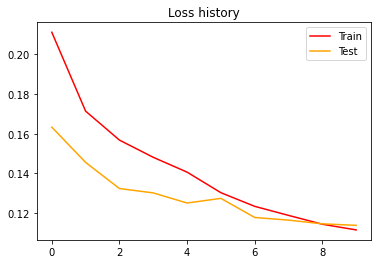

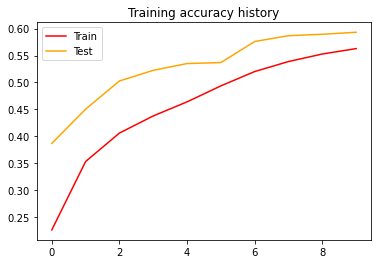

In [39]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history")

plt.show()

In [40]:
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

In [41]:
history_3 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 10 ===============================================
Epoch 1 completed in 811.81 seconds ! Loss: 0.0906 Acc: 0.6411
Val Loss: 0.0997 Val Acc: 0.65294s ...
Epoch: 2 / 10 ===============================================
Epoch 2 completed in 849.70 seconds ! Loss: 0.0850 Acc: 0.6629
Val Loss: 0.0986 Val Acc: 0.65814s ...
Epoch: 3 / 10 ===============================================
Epoch 3 completed in 814.93 seconds ! Loss: 0.0822 Acc: 0.6727
Val Loss: 0.0996 Val Acc: 0.66004s ...
Epoch: 4 / 10 ===============================================
Epoch 4 completed in 832.93 seconds ! Loss: 0.0800 Acc: 0.6819
Val Loss: 0.0998 Val Acc: 0.66255s ...
Epoch: 5 / 10 ===============================================
Epoch 5 completed in 839.08 seconds ! Loss: 0.0789 Acc: 0.6840
Val Loss: 0.0987 Val Acc: 0.66535s ...
Epoch: 6 / 10 ===============================================
Epoch 6 completed in 817.16 seconds ! Loss: 0.0773 Acc: 0.6889
Val Loss: 0.0982 Val Acc: 0.66695s ...
Epoch: 7 / 10 ==

In [42]:
train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = False, validate = True,
                shuffle = True)

Val Loss: 0.0991 Val Acc: 0.66934s ...


In [28]:
history_3 = [[0.0441,0.0413 ,0.0400,0.0392,0.0386],
            [0.6500,0.6718 ,0.6812,0.6860,0.6905],
            [0.0481,0.0476 ,0.0475,0.0469,0.0472],
            [0.6539,0.6591 ,0.6622,0.6624,0.6661]]

for i in range(4):
    history[i].extend(history_3[i])

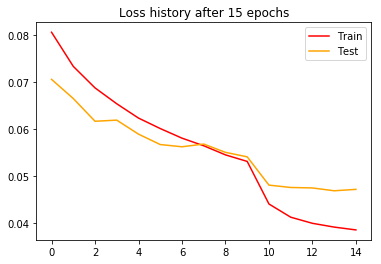

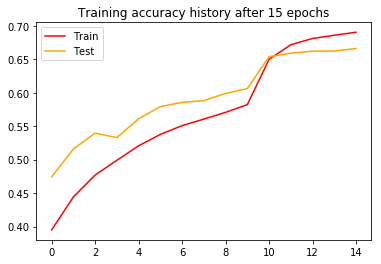

In [29]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history after 15 epochs")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history after 15 epochs")

plt.show()

## Without data augmentation + resize

In [18]:
prep1 = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [19]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'test']}

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=8,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [20]:
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(512, 101)

use_gpu = torch.cuda.is_available()
if use_gpu :
    model_resnet = model_resnet.cuda()

In [21]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_resnet = torch.optim.SGD(model_resnet.parameters(),lr = lr, momentum = 0.9)

In [ ]:
history_4 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 10,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 10 ===============================================
Epoch 1 completed in 959.81 seconds ! Loss: 0.4954 Acc: 0.1047
Val Loss: 0.4299 Val Acc: 0.21282s ...
Epoch: 2 / 10 ===============================================
Epoch 2 completed in 936.59 seconds ! Loss: 0.3949 Acc: 0.2564
Val Loss: 0.3664 Val Acc: 0.33172s ...
Epoch: 3 / 10 ===============================================
Epoch 3 completed in 983.84 seconds ! Loss: 0.3438 Acc: 0.3442
Val Loss: 0.3494 Val Acc: 0.36512s ...
Epoch: 4 / 10 ===============================================
Epoch 4 completed in 976.69 seconds ! Loss: 0.3080 Acc: 0.4074
Val Loss: 0.3219 Val Acc: 0.41662s ...
Epoch: 5 / 10 ===============================================
Epoch 5 completed in 1123.60 seconds ! Loss: 0.2782 Acc: 0.4588
Val Loss: 0.3085 Val Acc: 0.43392s ...
Epoch: 6 / 10 ===============================================
Epoch 6 completed in 1142.33 seconds ! Loss: 0.2489 Acc: 0.5079
Val Loss: 0.3155 Val Acc: 0.43456s ...
Epoch: 7 / 10 

In [13]:
history_4 = train_model(model=model_resnet,criterion=criterion,
              train_loaders = dset_loaders['train'],
                 test_loaders = dset_loaders['test'],
                  optimizer = optimizer_resnet,
                 epochs = 4,train = True, validate = True,
                shuffle = True)

Epoch: 1 / 4 ===============================================


NameError: name 'dset_sizes' is not defined

In [39]:
history_5 = [[0.0977,0.0753 ,0.0638,0.0542,0.0451,0.0363],
            [0.2851,0.4244 ,0.5005,0.5666,0.6303,0.6935],
            [0.0864 ,0.0832 ,0.0767,0.0798,0.0790,0.0860],
            [0.3547,0.3975 , 0.4368,0.4382,0.4487,0.4384]]

for i in range(4):
    history_5[i].extend(history_4[i])

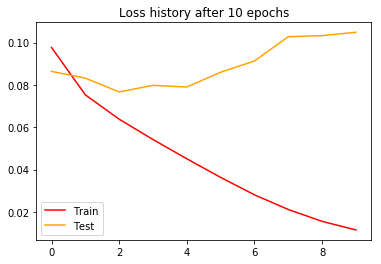

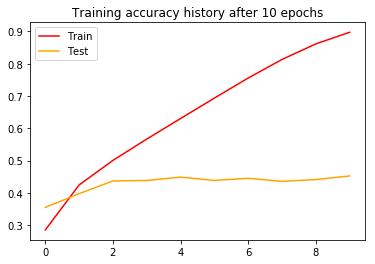

In [41]:
plt.figure(1)
plt.plot(history_5[0],color='red',label='Train')
plt.plot(history_5[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history after 10 epochs")

plt.figure(2)
plt.plot(history_5[1],color='red',label='Train')
plt.plot(history_5[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history after 10 epochs")

plt.show()